### Analysis of Hubway Trip Time to Bike Rentral Request in Boston

This project uses data from the City of Bostom to compare Hubway bike rental metrics (number of bike rentals per hour, rental duration, etc.) against weather data for each of the Hubway station. We set out to achieve the following:

1) Determine if correlations between weather variables (temperarure, humidity, etc.) and Hubway bike rental metrics (number of Hubway bike rental requests, average trip time, number of Hibway bike rental request per hour) exist. Does the Hubway have more registered users than casual users? What variables most influence the number of Hubway bike rental per hour?

2) Determine if there is a statistically significant difference between northern and southern community areas in bike rental duration or the number of number of bike rental per hour. Perform k-means clustering to discover if census data can accurately predict a northern or southern community area.

3) Create regression model using machine learning to predict trip time and number of bike rental per hour given weather data for a particular area. This model could be used to predict the bike demand in the city for any hubway station and provide an estimate of bike inventory to be maintained for any season.

In [27]:
%pylab inline

import re
import numpy as np
import pandas as pd
import time
from time import mktime
from datetime import date, datetime
from pandas.tseries.holiday import USFederalHolidayCalendar
import seaborn as sns
sns.set_style(style='white')
plt.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


/Users/subhabratamukherjee/anaconda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
Y = 2000 # dummy leap year to allow input X-02-29 (leap day)
seasons = [('winter', (date(Y,  1,  1),  date(Y,  3, 20))),
           ('spring', (date(Y,  3, 21),  date(Y,  6, 20))),
           ('summer', (date(Y,  6, 21),  date(Y,  9, 22))),
           ('autumn', (date(Y,  9, 23),  date(Y, 12, 20))),
           ('winter', (date(Y, 12, 21),  date(Y, 12, 31)))]

def get_season(now):
    if isinstance(now, datetime):
        now = now.date()
    now = now.replace(year=Y)
    return next(season for season, (start, end) in seasons
                if start <= now <= end)

#print(get_season(date.today()))

#### Importing data from csv

Link to dataset: http://hubwaydatachallenge.org/trip-history-data/

In [3]:
dfTrips = pd.read_csv('data/hubway_trips.csv',parse_dates=True, index_col='seq_id', na_values={''})

dfTrips.columns = ['HID','STA','DUR','SDT','SST','EDT','EST','BNR','SUB','ZIP','BDT','GND']

#### Cleaning the dataset

In [43]:
df1 = dfTrips.copy()

#Convert completion date from string to datetime object
cleanedStartDate = []
for date in df1['SDT']:
    if date != None:
        cleanedStartDate.append(datetime.strptime(date, '%m/%d/%Y %H:%M:%S'))
    else:
        cleanedStartDate.append(None)

cleanedEndDate = []
for date in df1['EDT']:
    if date != None:
        cleanedEndDate.append(datetime.strptime(date, '%m/%d/%Y %H:%M:%S'))
    else:
        cleanedEndDate.append(None)
        
df1.insert(3, 'CSD', cleanedStartDate)
df1.insert(5, 'CED', cleanedEndDate)

#Add a New Column 'Season'
df1['SEN'] = df1['CSD'].map(get_season)

#Convert 'start_station', 'end_station' and 'birth_date' to integers
df1['SST'] = df1['SST'].fillna(0.0).astype(int)
df1['EST'] = df1['EST'].fillna(0.0).astype(int)
df1['BDT'] = df1['BDT'].fillna(0.0).astype(int)

#Convert 'bike_number', 'subscription_type' and 'gender' to string
df1['BNR'] = df1['BNR'].fillna('').astype(str)
df1['SUB'] = df1['SUB'].fillna('').astype(str)
df1['GND'] = df1['GND'].fillna('').astype(str)

#Add column to describe the day of the week, Year, Month and Date
df1['DAY'] = df1['CSD'].dt.weekday_name
df1['YR']  = df1['CSD'].dt.year
df1['MN'] = df1['CSD'].dt.month
df1['DD']  = df1['CSD'].dt.day

cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=df1['CSD'].min(), end=df1['CSD'].max()).to_pydatetime()
df1['HOL'] = df1['CSD'].isin(holidays).astype(int)
df1['WDY'] = ((pd.DatetimeIndex(df1['CSD']).dayofweek) // 5 == 1).astype(int)
df1['BD'] = df1['HOL'] * df1['WDY']

#Delete original columns containing uncleaned data
del df1['SDT'], df1['EDT']

df1.head(5)

,HID,STA,DUR,CSD,CED,SST,EST,BNR,SUB,ZIP,BDT,GND,SEN,DAY,YR,MN,DD,HOL,WDY,BD
seq_id,,,,,,,,,,,,,,,,,,,,
1,8,Closed,9,2011-07-28 10:12:00,2011-07-28 10:12:00,23,23,B00468,Registered,'97217,1976,Male,summer,Thursday,2011,7,28,0,0,0
2,9,Closed,220,2011-07-28 10:21:00,2011-07-28 10:25:00,23,23,B00554,Registered,'02215,1966,Male,summer,Thursday,2011,7,28,0,0,0
3,10,Closed,56,2011-07-28 10:33:00,2011-07-28 10:34:00,23,23,B00456,Registered,'02108,1943,Male,summer,Thursday,2011,7,28,0,0,0
4,11,Closed,64,2011-07-28 10:35:00,2011-07-28 10:36:00,23,23,B00554,Registered,'02116,1981,Female,summer,Thursday,2011,7,28,0,0,0
5,12,Closed,12,2011-07-28 10:37:00,2011-07-28 10:37:00,23,23,B00554,Registered,'97214,1983,Female,summer,Thursday,2011,7,28,0,0,0


#### Data Exploration

To begin, we'll examine relationships in the Hubway trip data set. Later in the analysis, we will pull in weather data to understand each community areas's median salary, percentage of land zoned as residential, etc.
First, we'll look at two statements made by the City when introducing this dataset:

Hubway officially launched on July 28, 2011, with an event in which members could ride bicycles from City Hall Plaza to a designated bicycle station. The event featured Mayor Menino, representatives from various sponsors, and related agencies.[3] In November 2011, Hubway was shut down and disassembled for the winter as a preventive measure to counter New England winter weather.

On March 15, 2012, Hubway was relaunched for the season. By the end of the 2012 season on November 28, the system had 105 stations and 1,050 bikes. Again, Hubway was shut down and disassembled for the winter. The system reopened on April 2, 2013, and by the end of November 2013 had expanded to 130 stations and 1,200 bikes. While a majority of the stations were shut down again for the winter season, 25 stations in the City of Cambridge, Massachusetts, remained open during a winter pilot program. After the full system relaunched on April 2, 2014, the system grew to 140 stations and over 1,300 bikes.

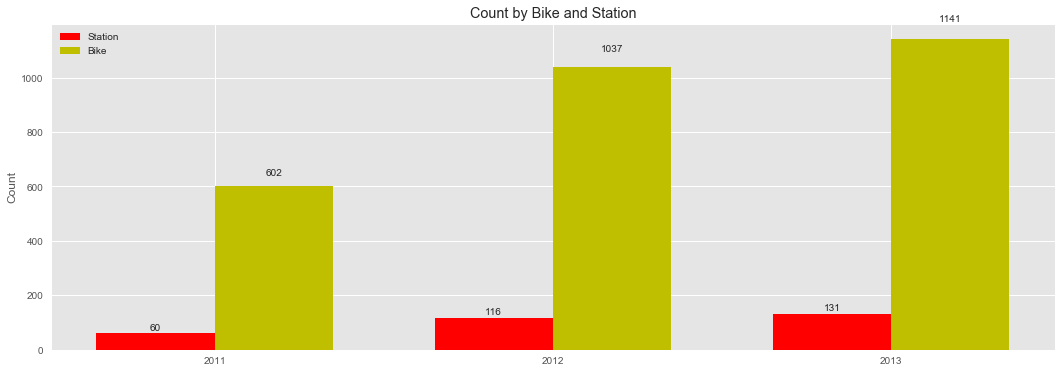

In [20]:
import numpy as np
import matplotlib.pyplot as plt

cnt1 = np.count_nonzero(unique(df1[df1['YR'] == 2011][['SST']]))
cnt2 = np.count_nonzero(unique(df1[df1['YR'] == 2012][['SST']]))
cnt3 = np.count_nonzero(unique(df1[df1['YR'] == 2013][['SST']]))

cnt4 = np.count_nonzero(unique(df1[df1['YR'] == 2011][['BNR']]))
cnt5 = np.count_nonzero(unique(df1[df1['YR'] == 2012][['BNR']]))
cnt6 = np.count_nonzero(unique(df1[df1['YR'] == 2013][['BNR']]))

N = 3
station_cnt = (cnt1, cnt2, cnt3)

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots(figsize=(18, 6))
rects1 = ax.bar(ind, station_cnt, width, color='r')

bike_cnt = (cnt4, cnt5, cnt6)

rects2 = ax.bar(ind + width, bike_cnt, width, color='y')

# add some text for labels, title and axes ticks
ax.set_ylabel('Count')
ax.set_title('Count by Bike and Station')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('2011', '2012', '2013'))

ax.legend((rects1[0], rects2[0]), ('Station', 'Bike'))

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()

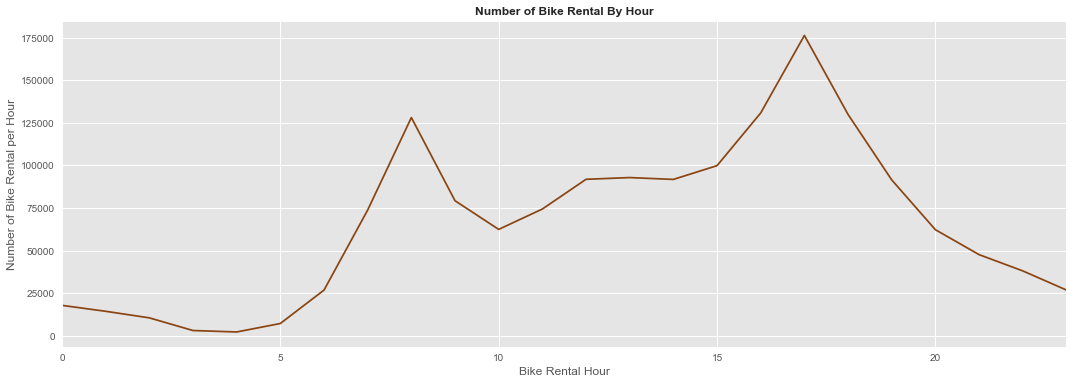

In [17]:
import matplotlib.pyplot as plt
import numpy as np

rentalByHr = df1.groupby(df1['CSD'].dt.hour)['CSD'].count()
fig = plt.figure(figsize=(18, 6))

rentalByHr.plot(color = 'saddlebrown')
plt.ylabel('Number of Bike Rental per Hour', fontsize = 12)
plt.xlabel('Bike Rental Hour', fontsize = 12)
plt.title('Number of Bike Rental By Hour', fontsize = 12, fontweight = 'bold');

plt.show()

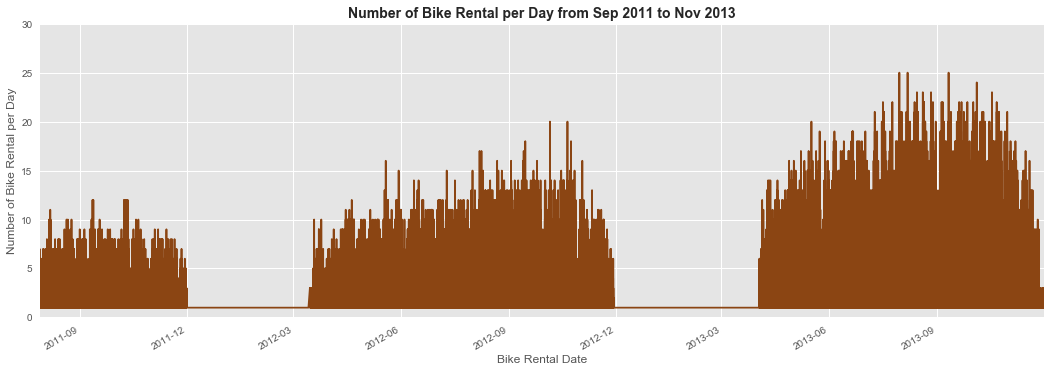

In [50]:
rentalByDate = df1.groupby('CSD')['CSD'].count()
fig = plt.figure(figsize=(18, 6))
rentalByDate.plot(color = 'saddlebrown')
#plt.xlim([datetime.datetime(2011, 1, 1, 0, 0), datetime.datetime(2013, 12, 31, 0, 0)])
plt.ylim([0,30])
plt.ylabel('Number of Bike Rental per Day', fontsize = 12)
plt.xlabel('Bike Rental Date', fontsize = 12)
plt.title('Number of Bike Rental per Day from Sep 2011 to Nov 2013', fontsize = 14, fontweight = 'bold');

plt.show()

In [56]:
df3 = rentalByDate.copy()

In [57]:
df3.reset_index()
df3.head(4)

ValueError: cannot insert CSD, already exists

In [54]:
df['DATE'] = df3['CSD'].dt.date

KeyError: 'CSD'

#### Importing Weather Data from csv

In [48]:
dfWeather = pd.read_csv('data/weather.csv',parse_dates=True)

#### Cleaning the dataset

In [49]:
df2 = dfWeather.copy()
df2[['Event']] = df2[['Event']].fillna(value='Clear')

df2.head()

,Cdate,Year,Month,Day,Thigh,Tavg,Tlow,Dhigh,Davg,Dlow,...,Pavg,Plow,Vhigh,Vavg,Vlow,Whigh,Wavg,Whigh.1,Precip,Event
0,1/1/2011,2011,Jan,1,56,46,35,43,37,29,...,30.04,29.96,10,9,6,15,6,18,0,Clear
1,1/2/2011,2011,Jan,2,51,45,38,46,41,26,...,29.88,29.79,10,5,0,24,7,31,0.15,Rain
2,1/3/2011,2011,Jan,3,38,34,29,22,12,8,...,29.98,29.80,10,10,9,26,15,35,0,Clear
3,1/4/2011,2011,Jan,4,39,32,25,18,16,13,...,29.89,29.71,10,10,10,20,10,24,0,Clear
4,1/5/2011,2011,Jan,5,39,34,28,20,15,8,...,29.73,29.69,10,10,10,25,12,31,0,Clear
